# M08T06 - Grover's Algorithm

> Demonstration of Grover's algorithm to perform unstructured search to solve a 2x2 Sudoku.



In [1]:
# scientific computing
import numpy as np

# qiskit sdk
import qiskit as qk
import qiskit.visualization as qkv

## Utility Functions to Initialize Circuit and Apply Gates

In [2]:
# list of gates that involve two qbits
single_qbit_gates = ['h', 'x', 'y', 'z']
two_qbit_gates = ['cnot', 'csx', 'cx', 'cy', 'cz', 'dcx', 'iswap']

def apply_gate(gate_func, qcirc, pos_a, pos_b=None):
    """Function to apply a quantum gate.

    Parameters
    ----------
        gate_func : :obj:`str`
            Gate function names available in QuantumCircuit class as strings.
        qcirc : :obj:`QuantumCircuit` 
            The quantum circuit.
        pos_a : int or list
            Position of the first qbit.
        pos_b : int, optional
            Position of the second qbit (inclusive).
    """

    # if single-qbit gate
    if gate_func in single_qbit_gates:
        # apply single-qbit gate
        getattr(qcirc, gate_func)(pos_a)
    # if two-qbit gate
    elif gate_func in two_qbit_gates:
        # handle second qbit
        pos_b = pos_a + 1 if pos_b is None else pos_b
        # apply two-qbit gate
        getattr(qcirc, gate_func)(pos_a, pos_b)
    # if multi-qbit controlled gate
    else:
        # handle control qbits
        controls = [pos_a] if type(pos_a) is not list else pos_a
        # handle target qbit
        target = controls[-1] + 1 if pos_b is None else pos_b
        getattr(qcirc, gate_func)(controls, target)

def apply_waterfall_gate(gate_func, qcirc, start, stop=None):
    """Function to apply a single-qbit or two-qbit quantum gate in a waterfall fashion.
    
    Parameters
    ----------
        gate_func : :obj:`str`
            Gate function names available in QuantumCircuit class as strings.
        qcirc : :obj:`QuantumCircuit`
            The quantum circuit.
        start : int
            Position of the first qbit.
        stop : int, optional
            Position of the last qbit (inclusive).
    """

    # if single-qbit gate
    if gate_func in single_qbit_gates:
        # handle stop
        stop = start if stop is None else stop
        # for each qbit
        for i in range(start, stop + 1):
            # apply the gate to the quantum circuit
            getattr(qcirc, gate_func)(i)
    # if two-qbit gate
    elif gate_func in two_qbit_gates:
        # handle stop
        stop = start + 1 if stop is None else stop
        # for each consecutive qbits
        for i in range(start, stop):
            # apply the gate to the quantum circuit
            getattr(qcirc, gate_func)(i, i + 1)

## Utility Functions to Execute Circuits

In [10]:
def execute_classic(qcirc, backend_name, shots=1):
    """Funtion to simulate the execution of the quantum circuit classically.

    Parameters
    ----------
        qcirc : :obj:`QuantumCircuit` 
            The quantum circuit.
        backend_name : :obj:`str`
            Name of the backend to use.
        shots : int
            Number of iterations.

    Returns
    -------
        A `Result` object for the job.
    """

    # list of available backends
    be_available = [be.name() for be in qk.Aer.backends()]
    # if backend is availale
    if backend_name in be_available:
        # get backend API for the simulation
        be = qk.Aer.get_backend(backend_name)
        # execute measurement
        job = qk.execute(qcirc, backend=be, shots=shots)
        # obtain measurement result
        return job.result()

def execute_quantum(qcirc, backend_name, shots=1):
    """Funtion to execute the quantum circuit on IBMQ.

    Parameters
    ----------
        qcirc : :obj:`QuantumCircuit` 
            The quantum circuit.
        backend_name : :obj:`str`
            Name of the backend to use.

    Returns
    -------
        A `Result` object for the job.
    """
    
    qk.IBMQ.load_account()
    # get backend provider for IBM Quantum
    be_provider = qk.IBMQ.get_provider('ibm-q')
    # list of available backends
    be_available = [be.name() for be in be_provider.backends()]
    # if backend is available
    if backend_name in be_available:
        # get backend API for the quantum computer
        be = be_provider.get_backend(backend_name)
        # execute measurement
        job = qk.execute(qcirc, backend=be, shots=shots)
        # monitor job
        qk.tools.job_monitor(job)
        # obtain measurement results
        return job.result()

## Function to Generate Constraints

In [11]:
def get_constraints(dim):
    """Function to obtain the list of constraints (edges) for a given dimension.

    Parameters
    ----------
        dim : int
            Dimension of the sudoku.
    
    Returns
    -------
        list_cons : list
            Constraints for the dimension as lists or tuples.
    """

    # TODO: Consider dimension.
    list_cons = [(0, 1), (0, 2), (1, 3), (2, 3)]

    return list_cons

## Oracle Function for Grover

In [12]:
def apply_oracle(qcirc, list_cons, poss_cons, qbit_out):
    
    for i in range(len(list_cons)):
        apply_gate('cx', qcirc, list_cons[i][0], poss_cons[i])
        apply_gate('cx', qcirc, list_cons[i][1], poss_cons[i])

    apply_gate('mct', qcirc, poss_cons, qbit_out)
    
    for i in range(len(list_cons)):
        apply_gate('cx', qcirc, list_cons[i][0], poss_cons[i])
        apply_gate('cx', qcirc, list_cons[i][1], poss_cons[i])

## Diffuser Function for Initialization

In [13]:
def get_diffuser(num_q):
    qcirc = qk.QuantumCircuit(num_q)
    
    apply_waterfall_gate('h', qcirc, 0, num_q - 1)
    
    apply_waterfall_gate('x', qcirc, 0, num_q - 1)

    apply_gate('h', qcirc, num_q - 1)
    
    apply_gate('mct', qcirc, list(range(0, num_q - 1)), num_q - 1)

    apply_gate('h', qcirc, num_q - 1)
    
    apply_waterfall_gate('x', qcirc, 0, num_q - 1)
    
    apply_waterfall_gate('h', qcirc, 0, num_q - 1)

    diffuser = qcirc.to_gate()
    diffuser.name = '$U_D$'
    
    return diffuser

## Quantum Circuit

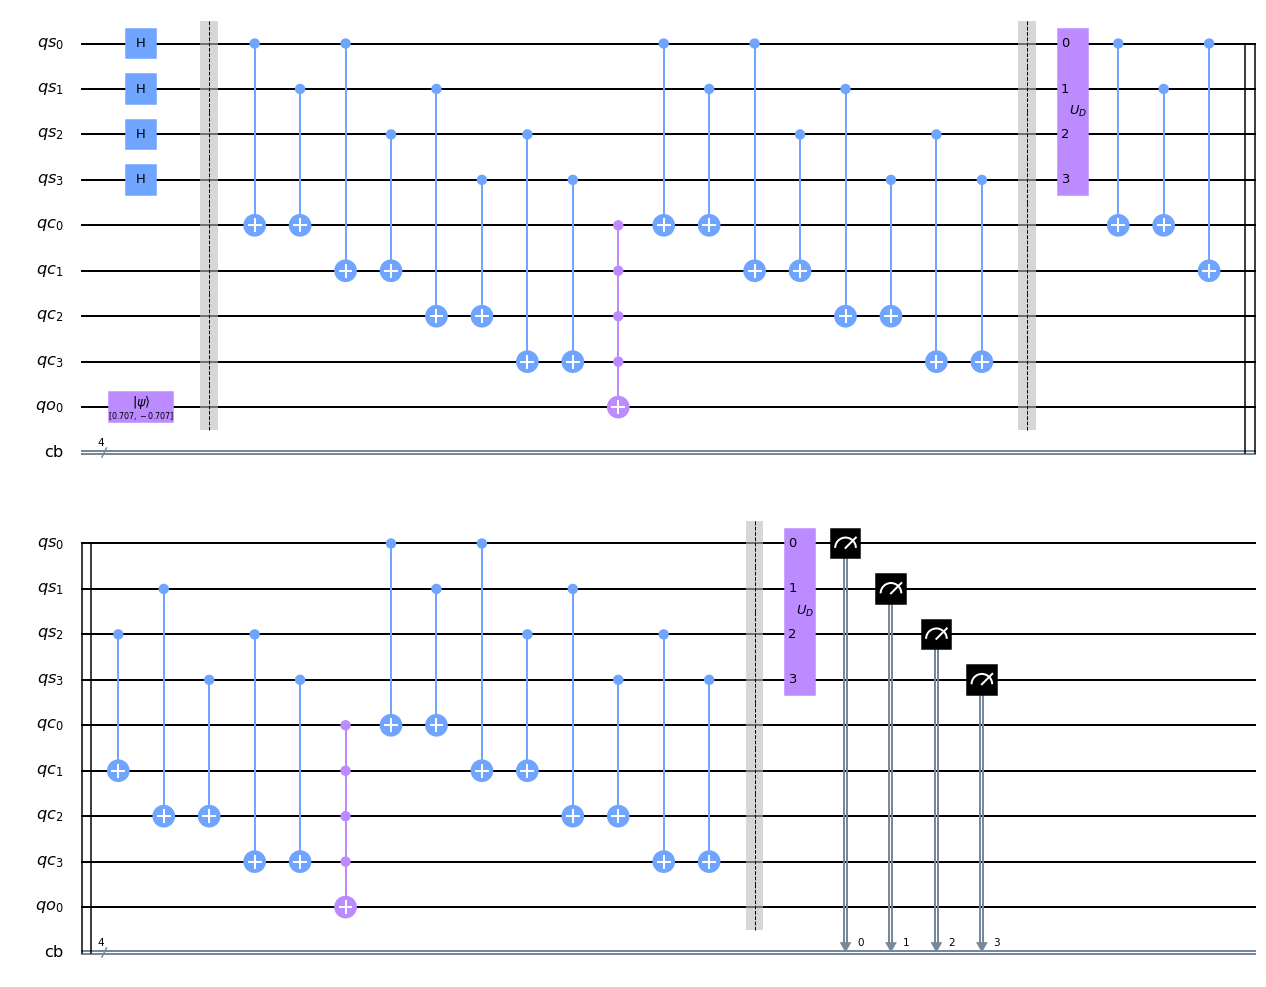

In [14]:
dim = 2
qbits_sudo = qk.QuantumRegister(dim**2, name='qs')
qbits_cons = qk.QuantumRegister(dim**2, name='qc')
qbits_outp = qk.QuantumRegister(1, name='qo')
cbits_sudo = qk.ClassicalRegister(dim**2, name='cb')
qcirc = qk.QuantumCircuit(qbits_sudo, qbits_cons, qbits_outp, cbits_sudo)

# initialize output
qcirc.initialize([1, -1] / np.sqrt(2), qbits_outp)

apply_waterfall_gate('h', qcirc, 0, dim**2 - 1)
qcirc.barrier()

apply_oracle(qcirc, get_constraints(dim), list(range(dim**2, 2 * dim**2)), 2 * dim**2)
qcirc.barrier()
qcirc.append(get_diffuser(dim**2), list(range(dim**2)))

apply_oracle(qcirc, get_constraints(dim), list(range(dim**2, 2 * dim**2)), 2 * dim**2)
qcirc.barrier()
qcirc.append(get_diffuser(dim**2), list(range(dim**2)))

qcirc.measure(qbits_sudo, cbits_sudo)

# visualize the circuit using matplotlib
qcirc.draw(output='mpl')

## Classical Simulation

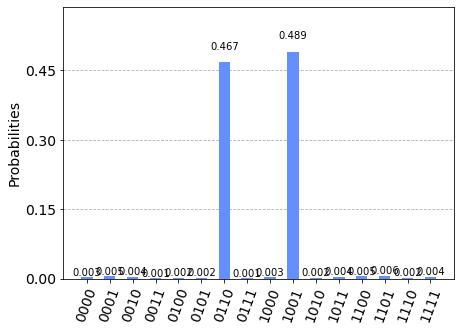

In [15]:
res = execute_classic(qcirc, 'qasm_simulator', shots=1000)
qkv.plot_histogram(res.get_counts())